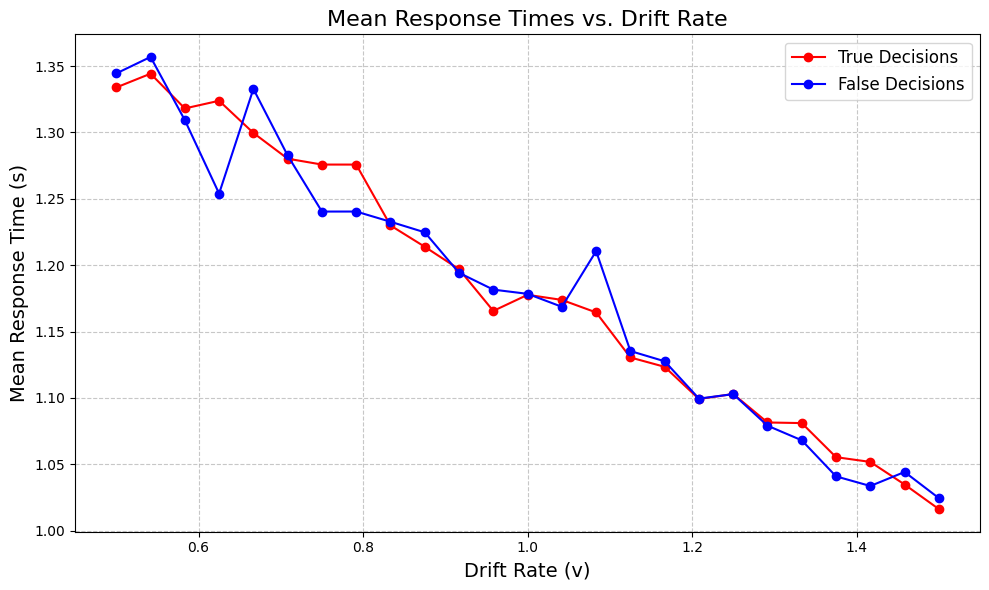

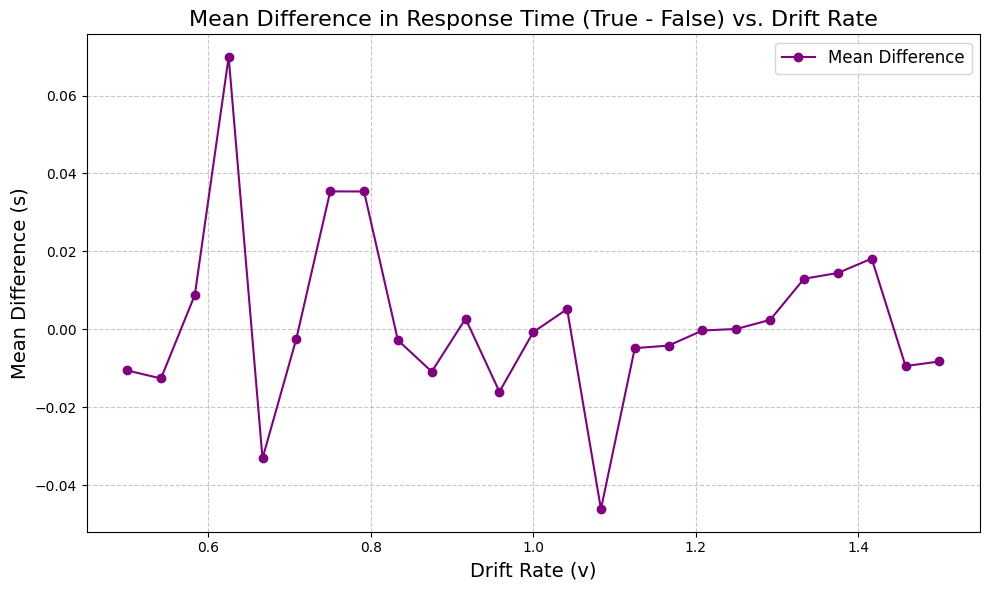

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

def simulate_diffusion(v, a, beta, tau, dt=1e-3, scale=1.0, max_time=10., rng=None):
    """
    Simulates one realization of the diffusion process given
    a set of parameters and a step size `dt`.

    Parameters:
    -----------
    v        : float
        The drift rate (rate of information uptake)
    a        : float
        The boundary separation (decision threshold).
    beta     : float in [0, 1]
        Relative starting point (prior option preferences)
    tau      : float
        Non-decision time (additive constant)
    dt       : float, optional (default: 1e-3 = 0.001)
        The step size for the Euler algorithm.
    scale    : float, optional (default: 1.0)
        The scale (sqrt(var)) of the Wiener process. Not considered
        a parameter and typically fixed to either 1.0 or 0.1.
    max_time : float, optional (default: .10)
        The maximum number of seconds before forced termination.
    rng      : np.random.Generator or None, optional (default: None)
        A random number generator with locally set seed or None
        If None provided, a new generator will be spawned within the function.
        
    Returns:
    --------
    (x, c) - a tuple of response time (y - float) and a 
        binary decision (c - int) 
    """

    # Inits (process starts at relative starting point)
    y = beta * a
    num_steps = tau
    const = scale*np.sqrt(dt)
    if rng is None:
        rng = np.random.default_rng()

    # Loop through process and check boundary conditions
    while (y <= a and y >= 0) and num_steps <= max_time:

        # Perform diffusion equation
        z = rng.normal()
        y += v*dt + const*z

        # Increment step counter
        num_steps += dt

    if y >= a:
        c = 1.
    else:
        c = 0.
    return (round(num_steps, 4), c)

def simulate_diffusion_n(num_sims, v, a, beta, tau, dt=1e-3, scale=1.0, max_time=10., rng=None):
    """Add a nice docstring."""

    # Inits
    data = np.zeros((num_sims, 2))
    if rng is None:
        rng = np.random.default_rng()
    
    # Create data set
    for n in range(num_sims):
        data[n, :] = simulate_diffusion(v, a, beta, tau, dt, scale, max_time, rng)
    return data

def visualize_data(data, figsize=(10, 5)):
    """Helper function to visualize a simple response time data set."""

    f, axarr = plt.subplots(1, 2, figsize=figsize)
    
    # Histogram of response times
    sns.histplot(
        data[:, 0][data[:, 1] == 1], ax=axarr[0], color='#AA0000', alpha=0.8, lw=2, label=f'Response 1')
    sns.histplot(
        data[:, 0][data[:, 1] == 0], ax=axarr[0], color='#0000AA', alpha=0.8, lw=2, label=f'Response 0')

    # Barplot of categorical responses
    response, frequency = np.unique(data[:, 1], return_counts=True)
    sns.barplot(x=response.astype(np.int32), y=frequency, ax=axarr[1], alpha=0.8, color='#00AA00')

    # Labels and embelishments
    axarr[0].set_xlabel('Response time (s)', fontsize=16)
    axarr[0].legend(fontsize=16)
    axarr[0].set_ylabel('Count', fontsize=16)
    axarr[1].set_xlabel('Response', fontsize=16)
    axarr[1].set_ylabel('Frequency', fontsize=16)
    for ax in axarr:
        sns.despine(ax=ax)
        ax.grid(alpha=0.1, color='black')

    f.suptitle('Data Summary', fontsize=18)

    f.tight_layout()

drift_variations = np.linspace(0.5, 1.5, num = 25)

mean_trend_true = []
mean_trend_false = []

for i in range(25):
    results = simulate_diffusion_n(2000, drift_variations[i], a = 2, beta = 0.5, tau = 0.4)

    mean_true = np.mean(results[:, 0][results[:, 1] == 1])
    mean_false = np.mean(results[:, 0][results[:, 1] == 0])
    mean_trend_true.append((drift_variations[i],mean_true))
    mean_trend_false.append((drift_variations[i],mean_false))

mean_trend_true = np.array(mean_trend_true)
mean_trend_false = np.array(mean_trend_false)

#--------------------------------------------------------------------------------------------------------------------------------

# Show the relationship between mean respones time versus drift rate
plt.figure(figsize=(10, 6))
plt.plot(mean_trend_true[:, 0], mean_trend_true[:, 1], label="True Decisions", color='red', marker='o', linestyle='-', markersize=6)
plt.plot(mean_trend_false[:, 0], mean_trend_false[:, 1], label="False Decisions", color='blue', marker='o', linestyle='-', markersize=6)
plt.xlabel('Drift Rate (v)', fontsize=14)
plt.ylabel('Mean Response Time (s)', fontsize=14)
plt.title('Mean Response Times vs. Drift Rate', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#--------------------------------------------------------------------------------------------------------------------------------

# Calculate the mean difference between true and false response times
mean_difference = mean_trend_true[:, 1] - mean_trend_false[:, 1]
plt.figure(figsize=(10, 6))
plt.plot(mean_trend_true[:, 0], mean_difference, label="Mean Difference", color='purple', marker='o', linestyle='-', markersize=6)
plt.xlabel('Drift Rate (v)', fontsize=14)
plt.ylabel('Mean Difference (s)', fontsize=14)
plt.title('Mean Difference in Response Time (True - False) vs. Drift Rate', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()




### **Observations on the Relationship Between Mean RT and Drift Rate**

#### 1. **Impact of Drift Rate Increase on RT:**
- **Decision (True):**  
  As the drift rate increases, the response time (RT) for true decisions (1) decreases.
  
- **Decision (False):**  
  Similarly, as the drift rate increases, the RT for false decisions (0) also decreases.

In both true and false decisions, an increase in drift rate leads to a reduction in RT. However, there are notable fluctuations in the RT for both true and false decisions, which might suggest some variability in the effect.

#### 2. **Impact of Drift Rate Increase on Mean Difference:**
- The relationship between mean difference and drift rate shows fluctuations in RT for both true and false decisions. A **positive mean difference** indicates that the true decision has a higher RT compared to the false decision. Conversely, a **negative mean difference** suggests that the false decision has a higher RT compared to the true decision.

Despite these observations, the relationship between the drift rate and mean difference appears erratic, making it difficult to draw definitive conclusions.


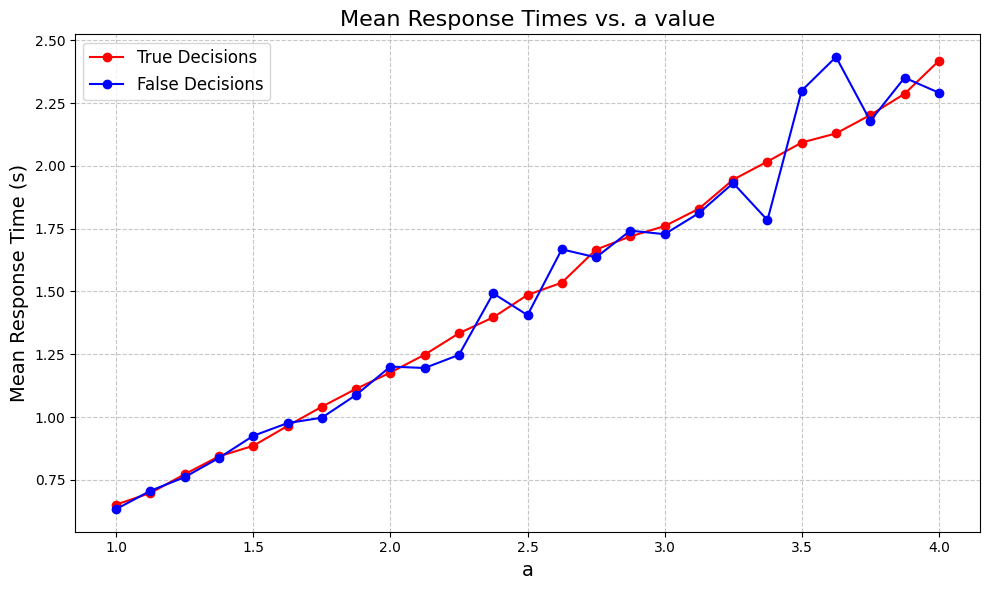

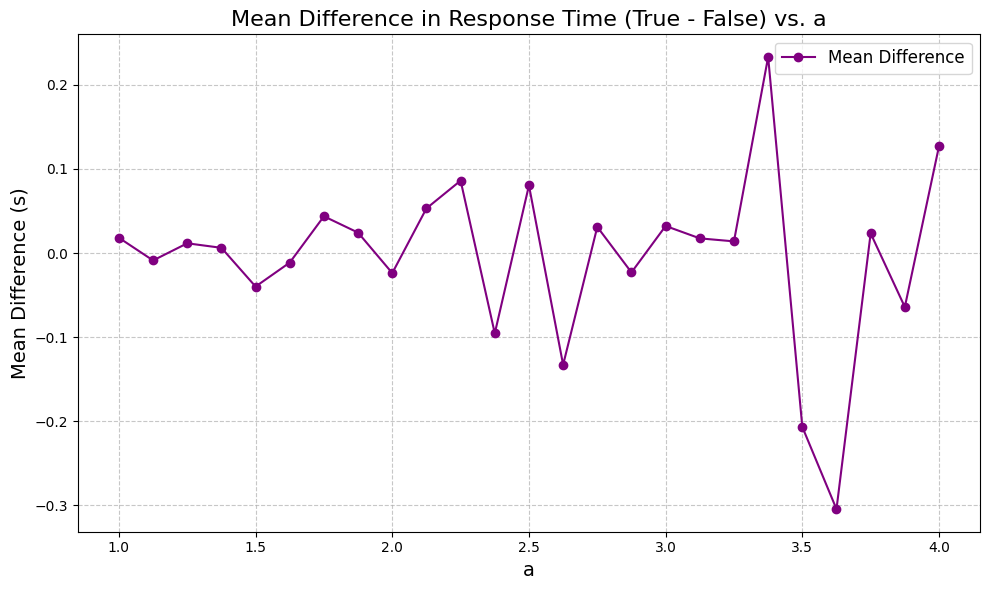

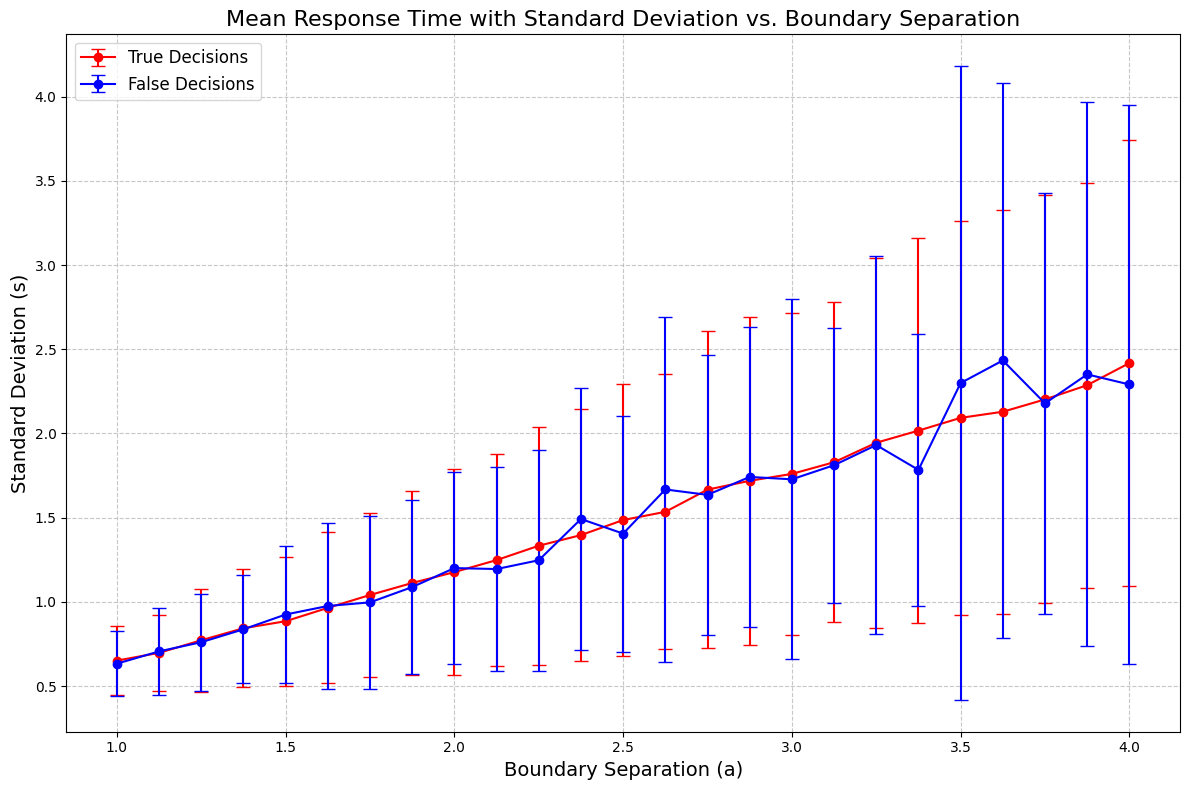

In [45]:

a_variations = np.linspace(1, 4, num = 25)

mean_trend_true = []
mean_trend_false = []

std_trend_true = []
std_trend_false = []

for i in range(25):
    results = simulate_diffusion_n(2000, v=1, a=a_variations[i], beta=0.5, tau=0.4)
    mean_true = np.mean(results[:, 0][results[:, 1] == 1])
    mean_false = np.mean(results[:, 0][results[:, 1] == 0])
    mean_trend_true.append((a_variations[i], mean_true))  
    mean_trend_false.append((a_variations[i], mean_false)) 
    
    std_true = np.std(results[:, 0][results[:, 1] == 1])
    std_false = np.std(results[:, 0][results[:, 1] == 0])
    std_trend_true.append((a_variations[i], mean_true, std_true))
    std_trend_false.append((a_variations[i], mean_false, std_false))

mean_trend_true = np.array(mean_trend_true)
mean_trend_false = np.array(mean_trend_false)

std_trend_true = np.array(std_trend_true)
std_trend_false = np.array(std_trend_false)

#--------------------------------------------------------------------------------------------------------------------------------

# Show the relationship between mean respones time versus a value
plt.figure(figsize=(10, 6))
plt.plot(mean_trend_true[:, 0], mean_trend_true[:, 1], label="True Decisions", color='red', marker='o', linestyle='-', markersize=6)
plt.plot(mean_trend_false[:, 0], mean_trend_false[:, 1], label="False Decisions", color='blue', marker='o', linestyle='-', markersize=6)
plt.xlabel('a', fontsize=14)
plt.ylabel('Mean Response Time (s)', fontsize=14)
plt.title('Mean Response Times vs. a value', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#--------------------------------------------------------------------------------------------------------------------------------

# Calculate the mean difference between true and false response times
mean_difference = mean_trend_true[:, 1] - mean_trend_false[:, 1]
plt.figure(figsize=(10, 6))
plt.plot(mean_trend_true[:, 0], mean_difference, label="Mean Difference", color='purple', marker='o', linestyle='-', markersize=6)
plt.xlabel('a', fontsize=14)
plt.ylabel('Mean Difference (s)', fontsize=14)
plt.title('Mean Difference in Response Time (True - False) vs. a', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#--------------------------------------------------------------------------------------------------------------------------------

# Plot Mean and Standard Deviation for True and False Decisions
plt.figure(figsize=(12, 8))
plt.errorbar(std_trend_true[:, 0], std_trend_true[:, 1], yerr=std_trend_true[:, 2], label="True Decisions", 
             fmt='-o', color='red', markersize=6, capsize=5)
plt.errorbar(std_trend_false[:, 0], std_trend_false[:, 1], yerr=std_trend_false[:, 2], label="False Decisions", 
             fmt='-o', color='blue', markersize=6, capsize=5)
plt.xlabel('Boundary Separation (a)', fontsize=14)
plt.ylabel('Standard Deviation (s)', fontsize=14)
plt.title('Mean Response Time with Standard Deviation vs. Boundary Separation', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### **Boundary Separation Relationship**

- **Mean RTs:**  
  The graphs indicate that as the boundary separation (\( a \)) increases, the decision time also increases. This trend is observed for both True (1) and False (0) decisions.

- **RT Difference:**  
  As the boundary value (\( a \)) increases, the mean difference in response times also grows. This suggests that the decision times for True and False choices are diverging further from each other.

- **Standard Deviations:**  
  The standard deviation for both boundaries generally increases as \( a \) becomes larger. This may suggest that a higher boundary separation represents a greater lack of information required to make a decision, leading to increased unpredictability, as reflected in the standard deviation graph.


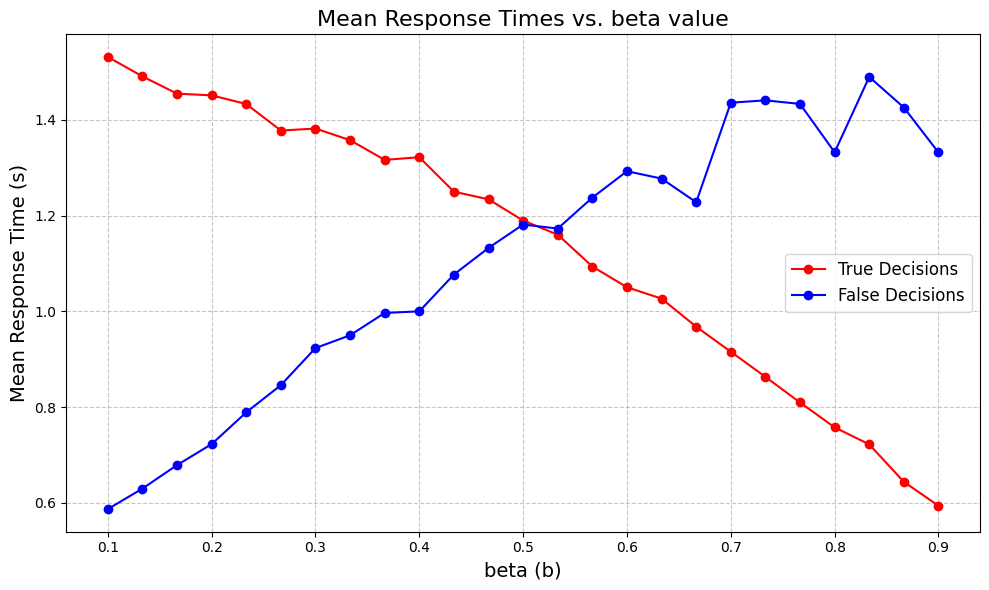

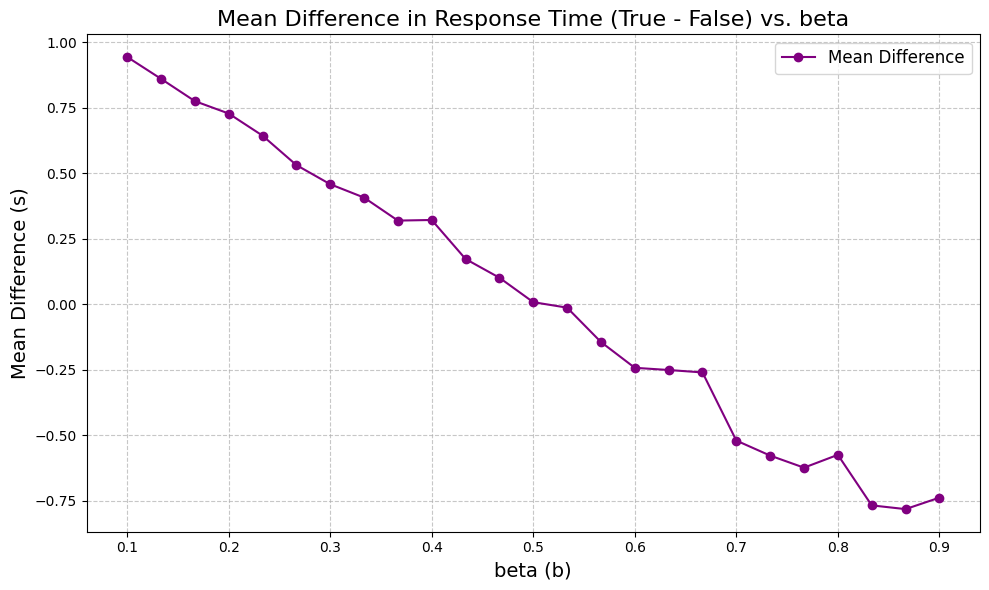

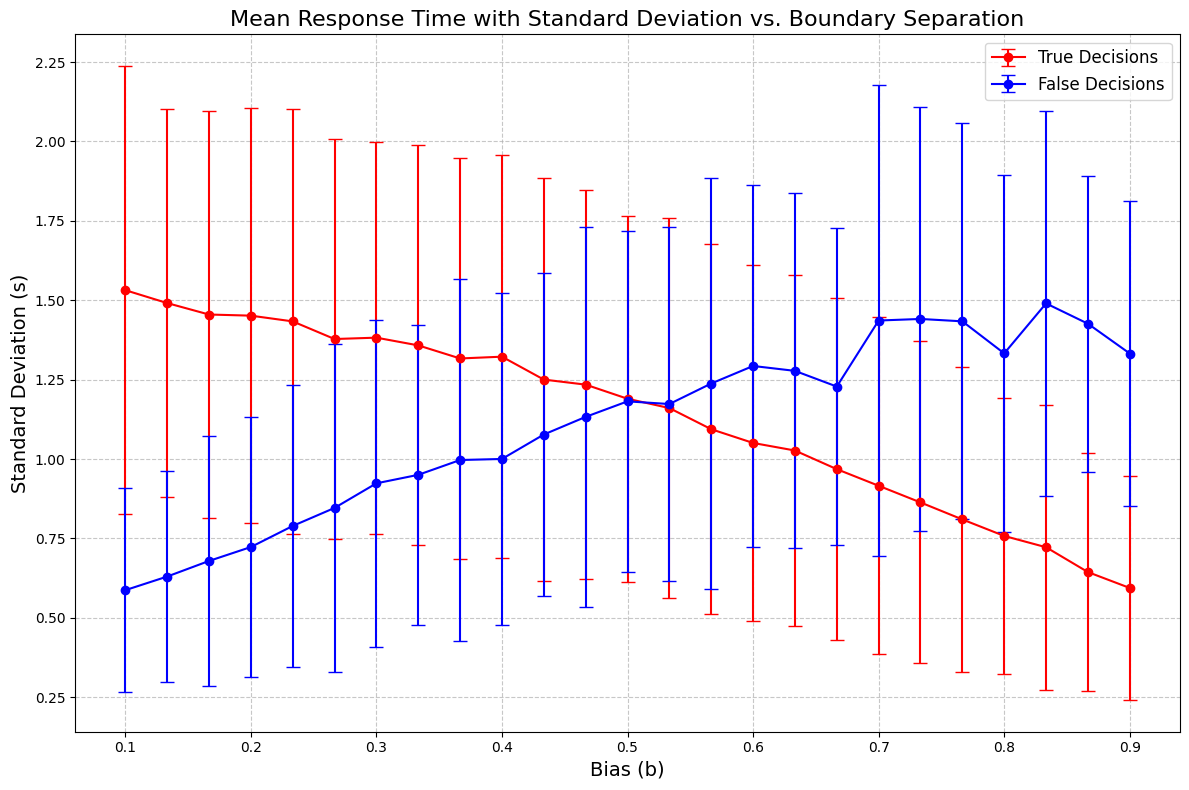

In [46]:

beta_variations = np.linspace(0.1, 0.9, num = 25)

mean_trend_true = []
mean_trend_false = []

std_trend_true = []
std_trend_false = []

for i in range(25):
    results = simulate_diffusion_n(2000, v=1, a=2, beta=beta_variations[i], tau=0.4)
    mean_true = np.mean(results[:, 0][results[:, 1] == 1])
    mean_false = np.mean(results[:, 0][results[:, 1] == 0])
    mean_trend_true.append((beta_variations[i], mean_true))  
    mean_trend_false.append((beta_variations[i], mean_false)) 
    
    std_true = np.std(results[:, 0][results[:, 1] == 1])
    std_false = np.std(results[:, 0][results[:, 1] == 0])
    std_trend_true.append((beta_variations[i], mean_true, std_true))
    std_trend_false.append((beta_variations[i], mean_false, std_false))

mean_trend_true = np.array(mean_trend_true)
mean_trend_false = np.array(mean_trend_false)

std_trend_true = np.array(std_trend_true)
std_trend_false = np.array(std_trend_false)

#--------------------------------------------------------------------------------------------------------------------------------

# Show the relationship between mean respones time versus a value
plt.figure(figsize=(10, 6))
plt.plot(mean_trend_true[:, 0], mean_trend_true[:, 1], label="True Decisions", color='red', marker='o', linestyle='-', markersize=6)
plt.plot(mean_trend_false[:, 0], mean_trend_false[:, 1], label="False Decisions", color='blue', marker='o', linestyle='-', markersize=6)
plt.xlabel('beta (b)', fontsize=14)
plt.ylabel('Mean Response Time (s)', fontsize=14)
plt.title('Mean Response Times vs. beta value', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#--------------------------------------------------------------------------------------------------------------------------------

# Calculate the mean difference between true and false response times
mean_difference = mean_trend_true[:, 1] - mean_trend_false[:, 1]
plt.figure(figsize=(10, 6))
plt.plot(mean_trend_true[:, 0], mean_difference, label="Mean Difference", color='purple', marker='o', linestyle='-', markersize=6)
plt.xlabel('beta (b)', fontsize=14)
plt.ylabel('Mean Difference (s)', fontsize=14)
plt.title('Mean Difference in Response Time (True - False) vs. beta', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#--------------------------------------------------------------------------------------------------------------------------------

# Plot Mean and Standard Deviation for True and False Decisions
plt.figure(figsize=(12, 8))
plt.errorbar(std_trend_true[:, 0], std_trend_true[:, 1], yerr=std_trend_true[:, 2], label="True Decisions", 
             fmt='-o', color='red', markersize=6, capsize=5)
plt.errorbar(std_trend_false[:, 0], std_trend_false[:, 1], yerr=std_trend_false[:, 2], label="False Decisions", 
             fmt='-o', color='blue', markersize=6, capsize=5)
plt.xlabel('Bias (b)', fontsize=14)
plt.ylabel('Standard Deviation (s)', fontsize=14)
plt.title('Mean Response Time with Standard Deviation vs. Boundary Separation', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### **Bias (beta) Relationship**

- **Mean RTs:**  
  As the prior preference (\(\beta\)) increases, the mean response time (RT) for True decisions decreases. This aligns with the model's expectation that a higher bias toward True decisions enables the model to determine them more quickly. Conversely, this results in a pronounced opposite effect for False decisions, increasing their RT.

- **RT Difference:**  
  As the RT for True responses decreases while the RT for False responses increases, the mean difference trends below zero. This indicates that the gap between the two response times becomes more negative as \(\beta\) increases.

- **Standard Deviations:**  
  The standard deviation for False decisions increases, becoming more volatile compared to True decisions. This suggests that as bias shifts strongly toward True, False decisions become rarer and more unpredictable. Conversely, the standard deviation for True decisions decreases, reflecting reduced uncertainty as the model increasingly favors True responses.


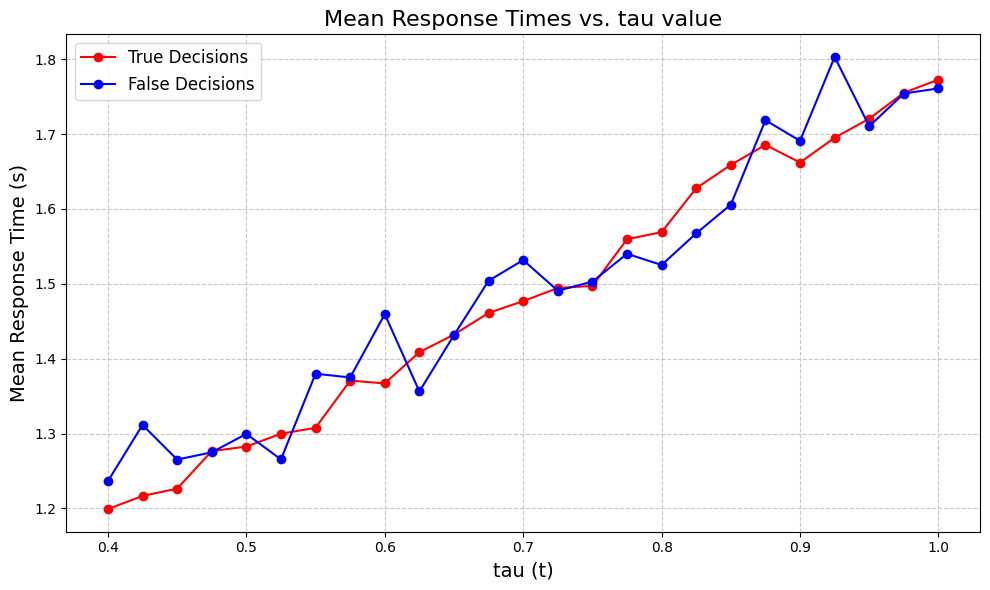

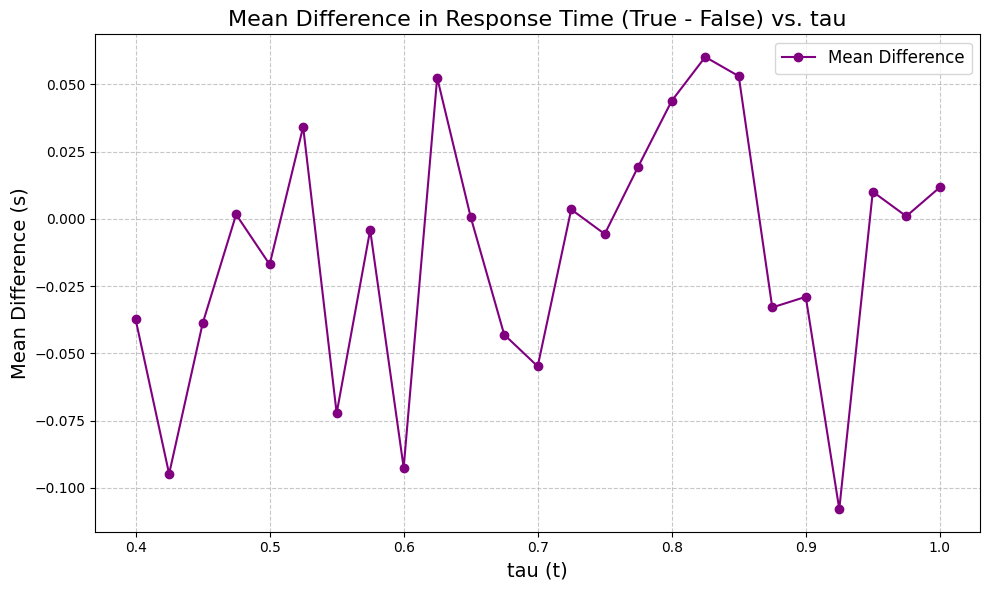

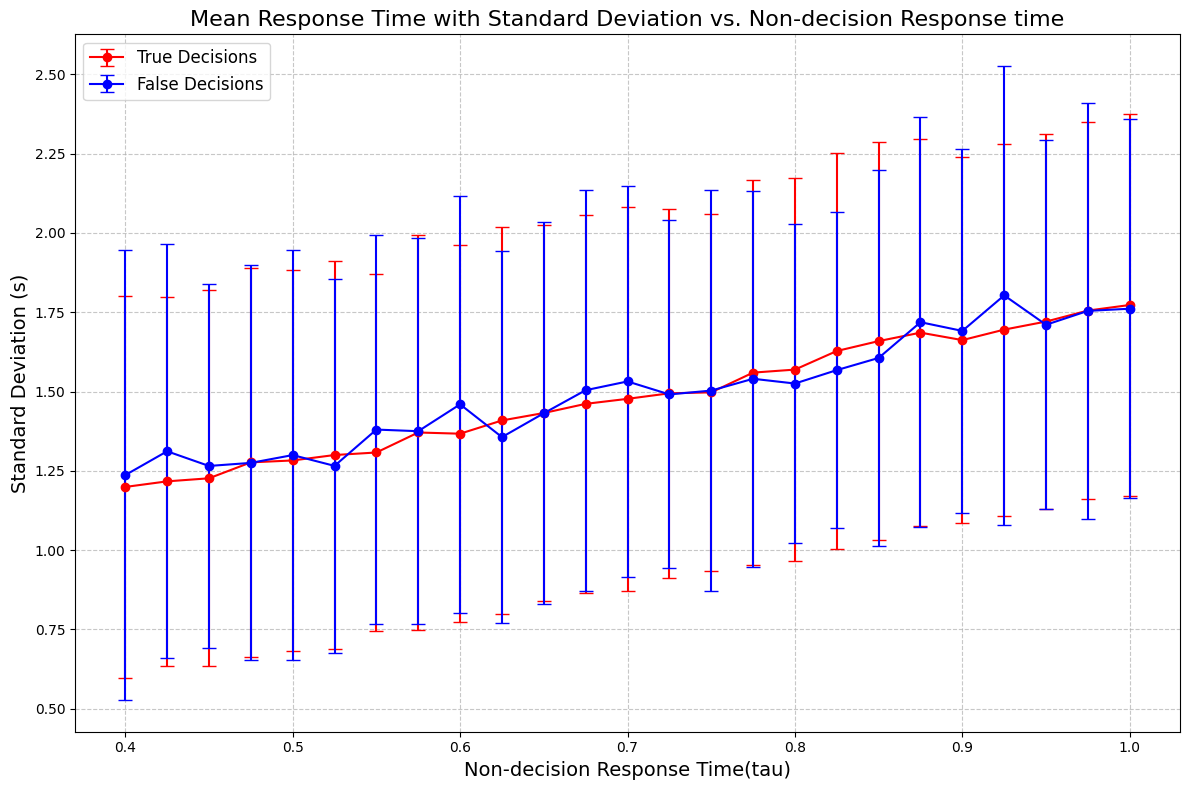

In [47]:

tau_variations = np.linspace(0.4, 1, num = 25)

mean_trend_true = []
mean_trend_false = []

std_trend_true = []
std_trend_false = []

for i in range(25):
    results = simulate_diffusion_n(2000, v=1, a=2, beta=0.5, tau=tau_variations[i])
    mean_true = np.mean(results[:, 0][results[:, 1] == 1])
    mean_false = np.mean(results[:, 0][results[:, 1] == 0])
    mean_trend_true.append((tau_variations[i], mean_true))  
    mean_trend_false.append((tau_variations[i], mean_false)) 
    
    std_true = np.std(results[:, 0][results[:, 1] == 1])
    std_false = np.std(results[:, 0][results[:, 1] == 0])
    std_trend_true.append((tau_variations[i], mean_true, std_true))
    std_trend_false.append((tau_variations[i], mean_false, std_false))

mean_trend_true = np.array(mean_trend_true)
mean_trend_false = np.array(mean_trend_false)

std_trend_true = np.array(std_trend_true)
std_trend_false = np.array(std_trend_false)

#--------------------------------------------------------------------------------------------------------------------------------

# Show the relationship between mean respones time versus a value
plt.figure(figsize=(10, 6))
plt.plot(mean_trend_true[:, 0], mean_trend_true[:, 1], label="True Decisions", color='red', marker='o', linestyle='-', markersize=6)
plt.plot(mean_trend_false[:, 0], mean_trend_false[:, 1], label="False Decisions", color='blue', marker='o', linestyle='-', markersize=6)
plt.xlabel('tau (t)', fontsize=14)
plt.ylabel('Mean Response Time (s)', fontsize=14)
plt.title('Mean Response Times vs. tau value', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#--------------------------------------------------------------------------------------------------------------------------------

# Calculate the mean difference between true and false response times
mean_difference = mean_trend_true[:, 1] - mean_trend_false[:, 1]
plt.figure(figsize=(10, 6))
plt.plot(mean_trend_true[:, 0], mean_difference, label="Mean Difference", color='purple', marker='o', linestyle='-', markersize=6)
plt.xlabel('tau (t)', fontsize=14)
plt.ylabel('Mean Difference (s)', fontsize=14)
plt.title('Mean Difference in Response Time (True - False) vs. tau', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#--------------------------------------------------------------------------------------------------------------------------------

# Plot Mean and Standard Deviation for True and False Decisions
plt.figure(figsize=(12, 8))
plt.errorbar(std_trend_true[:, 0], std_trend_true[:, 1], yerr=std_trend_true[:, 2], label="True Decisions", 
             fmt='-o', color='red', markersize=6, capsize=5)
plt.errorbar(std_trend_false[:, 0], std_trend_false[:, 1], yerr=std_trend_false[:, 2], label="False Decisions", 
             fmt='-o', color='blue', markersize=6, capsize=5)
plt.xlabel('Non-decision Response Time(tau)', fontsize=14)
plt.ylabel('Standard Deviation (s)', fontsize=14)
plt.title('Mean Response Time with Standard Deviation vs. Non-decision Response time', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### **Non-Decision Time (\(\tau\)) Relationship**

- **Mean RTs:**  
  As \(\tau\) increases, the response time for both True and False decisions also increases. This is expected, as \(\tau\) represents non-decision time, meaning that higher values naturally lead to longer overall response times.

- **RT Difference:**  
  The difference in response times appears sporadic, with no clear trend emerging.

- **Standard Deviations:**  
  The standard deviation gradually increases alongside the overall response time. This suggests that the rise in response time may be contributing to the increase in variability.
